<a href="https://colab.research.google.com/github/muhammadali74/My_CUDA_Repo/blob/main/sn07590_Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 01
- GPU Accelerated Computing
- Syed Muhammad Ali Naqvi
- sn07590

### Notebook Initialization Code

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-6nb7zytc
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-6nb7zytc
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.0.3-py3-none-any.whl size=7432 sha256=ad99cf1e6175f37f13398802e9e82d42885745e385f9d1c2ce678f3d359f3a95
  Stored in directory: /tmp/pip-ephem-wheel-cache-fqnacfe0/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Source files will be saved in "/tmp/tmpn_5slh9l".


In [ ]:
!nvidia-smi

Mon Jan 29 02:45:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Question No 01

- In this question, we compare the time for initializing an array of randomly geenrated numbers of CPU and GPU. we use rand() for initializing array on CPU and cuRand() API to initialize random numbers array on GPU.
- Same time measure (cudaEvent) is used to record all times to ensure consistency.
- The code along with references are as below

In [2]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <curand_kernel.h>

// error handler
inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

/*
Reference: 1. https://docs.nvidia.com/cuda/curand/device-api-overview.html#bit-generation-1
2. https://stackoverflow.com/questions/26650391/generate-random-number-within-a-function-with-curand-without-preallocation

*/

// kernel function for initilaization on gpu
__global__ void populate_device(int* arr, int N) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    curandState state;
    curand_init(i, 0, 0, &state); // Passing i as seed.
    if (i < N) {
        arr[i] = curand(&state);
    }

}
/*
Nvidia website suggests initializing curand state in a seperate kernel function and then copying the state from global to local memory orrandom number generation.
However, we get a significant initialization performance improvement as compared to CPU even though we use an inefficient approach (i.e calling curand_init()) in each kernel launch.
*/

// host function for same task
void populate_host(int* arr, int N) {
    for (int i = 0; i<N; i++)
      arr[i] = rand();
}

int main() {
    int *h_arr = 0; // host memory array pointer
    int *d_arr = 0; // device memory array pointer

    int N = 1000000;
    int numThreadsPerBlock = 256;
    int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);

    size_t size = N * sizeof(int);

    // allocate host memory
    h_arr = (int*)malloc(size);

    //allocate device memory
	  checkCudaErr(cudaMalloc((void**)&d_arr, size), "gpu memory allocation");

    // using cudaEvent to record times
    cudaEvent_t start, stop;
	  checkCudaErr(cudaEventCreate(&start), "Start Event Creation");
	  checkCudaErr(cudaEventCreate(&stop), "Stop Event Creation");
    // variables for storing recorded times
    float cputime = 0;
    float gputime = 0;
    float datacopytime = 0;

    //initialize on host and record time
    checkCudaErr(cudaEventRecord(start), "event record");
    populate_host(h_arr, N);
    checkCudaErr(cudaEventRecord(stop), "event record");
    checkCudaErr(cudaEventSynchronize(stop), "event synchronize");
    cudaEventElapsedTime(&cputime, start, stop);


    //output result
    /*
      printf("Host initialization result: \n");
      for(int i=0;i<N;++i) {
        printf("%d element =  %d\n", i, h_arr[i]);
        //clear host result to ensure that the result of device is actually from the kernel
        h_arr[i] = 0;
      }
    */


    //populate data on device
    checkCudaErr(cudaEventRecord(start), "event record");
    populate_device<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_arr, N);
    checkCudaErr(cudaGetLastError(), "GPU Error");
    checkCudaErr(cudaDeviceSynchronize(), "synchronize");
    checkCudaErr(cudaEventRecord(stop), "event record");
    checkCudaErr(cudaEventSynchronize(stop), "event synchronize");

    cudaEventElapsedTime(&gputime, start, stop);


    	//copy result from device to host
    checkCudaErr(cudaEventRecord(start), "event record");
	  checkCudaErr(cudaMemcpy(h_arr, d_arr, size, cudaMemcpyDeviceToHost), "data copy");
    checkCudaErr(cudaEventRecord(stop), "event record");
    checkCudaErr(cudaEventSynchronize(stop), "event synchronize");
    cudaEventElapsedTime(&datacopytime, start, stop);

 	//output result
	/*
	printf("--------------------------------------\n");
	printf("Device init result: \n");
	for(int i=0;i<N;++i) {
		printf("%3d = %3d\n", i, h_arr[i]);
	}
	printf("--------------------------------------\n");
	*/


  printf("Total time to generate data on CPU: %f msecs\n", cputime);
  printf("Total time to generate data on GPU: %f msecs\n", gputime);
  printf("Total time to copy data from device to host: %f msecs\n", datacopytime);

	//delete data allocated on device
	checkCudaErr(cudaFree(d_arr), "device mem deallocation");

	//delete host memory
	free(h_arr);
	cudaDeviceReset();
	return 0;

}



KeyboardInterrupt: 

#### Output
- Time Take to generate data on CPU: 25 msecs approx
- Time taken to generate data on GPU: 4.5 msecs approx
- Time taken to copy data from device to host: 0.9 msecs approx

Hence we observe that the time taken for GPU to initialize data is less than the CPU. This is beacause CPU initializes array randomly but GPU does it in parallel. It is however important to note that calling curand_init() in the same kernel function reduces the performance of GPU threads and makes them slower, but despite that, we get a significant performance difference

### Question No 02

- In this question, we calculate sum of n elements of an array.
- We can observe that we have data dependency in the code. One approach is to calculate partial sum on each thread and then adding the partial threads to the result variable, however, this approach is still linear in asymptoic time.
- Our approach works by adding pairs of elements in parallel repeatedly until only 1 element is left. Since each pair can be added on a seperate thread, therefore, we need to call the kernel log(n) times. Hence the complexity of the code reduces from linear to logarithmic time. Although a small bit of CPU code also plays some part in device sum, however, the summation calculations purely take place in GPU.
- Same time measure is used to ensure consistency

In [116]:

%%cuda
#include <stdio.h>

// The base of this code is https://github.com/muhammadali74/CUDA_Spring_2024/blob/main/Week3/Calculate_SumOnGPU_Timed.ipynb, courtesy of Dr Mobeen Movania's CuDA course content

// error handler
inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}



// kernel function for sum
__global__ void sum(unsigned long int* c, unsigned long int *result, const int numElems, const int prev) {
	int i = threadIdx.x + blockDim.x * blockIdx.x;
	if (i<numElems) {
			 int k = 2*i;
			 if (i == numElems-1 && prev %2 != 0) {
						result[i] = c[k] + c[k+1] + c[k+2]; // if we have odd number of elements
			 }
			 else {
			 result[i] = c[k] + c[k+1];
			 }
	}
}

// host function for sum
unsigned long int sum_host(unsigned long int* c, const int N) {
	unsigned long int summ = 0;
	for(int i=0; i<N; ++i){
		summ += c[i];}
	return summ;
}


int main() {

	unsigned long int* h_c = 0;

	unsigned long int* d_c = 0;
	unsigned long int sumhost = 0; // to store the final sum calculated on host
	unsigned long int* dresult = 0; // an array to store partial answers
	unsigned long int sumdev = 0; // to store the final sum calculated on device


  int N_list[] = {1000, 10000, 100000, 1000000}; // different data sizes
  int numThreadsPerBlock_list[] = {128, 256, 512}; // different threads per block for different execution configurations

  int N = 0;

  for (int m = 0; m<4; m++) {
      for (int k = 0; k < 3; k++) {


	N = N_list[m];
	int numThreadsPerBlock =  numThreadsPerBlock_list[k];

	int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);

  printf("Number of elements = %d\n", N );
	printf("Num threads per block: %3d\n", numThreadsPerBlock);
	printf("Num blocks per grid: %3d\n", numBlocksPerGrid);

	size_t size = N * sizeof(unsigned long int);

	//allocate host memory

	h_c = (unsigned long int*)malloc(size);

	//initialize c
	for(int i=0;i<N;++i) {
		h_c[i] = i+1;
	}

  cudaEvent_t start, stop;
	checkCudaErr(cudaEventCreate(&start), "Start Event Creation");
	checkCudaErr(cudaEventCreate(&stop), "Stop Event Creation");
  float cputime = 0;
  float gputime = 0;


	//allocate device memory
	checkCudaErr(cudaMalloc((void**)&d_c, size), "gpu memory allocation");
	checkCudaErr(cudaMalloc((void**)&dresult, size), "gpu memory allocation");



	//copy host data to device memory
	checkCudaErr(cudaMemcpy(d_c, h_c, size, cudaMemcpyHostToDevice),"data copy");
	checkCudaErr(cudaMemcpy(dresult, h_c, size, cudaMemcpyHostToDevice),"data coopy");

	//calculate on host
  checkCudaErr(cudaEventRecord(start), "event record");
	sumhost = sum_host(h_c, N);
  checkCudaErr(cudaEventRecord(stop), "event record");
  checkCudaErr(cudaEventSynchronize(stop), "event synchronize");
  cudaEventElapsedTime(&cputime, start, stop);

 printf("Sum (host): %lu\n", sumhost);


	int div = N/2; // division at each step
	int prev = N;
	int bit = 1; // to interchange the arrays for repeatitive calculation
	int last = 0; // to determine in which array is the answer stored.


	checkCudaErr(cudaEventRecord(start), "event record");
	//calculate on device
	while (div > 0) {

	if (bit > 0 ) {
	     sum<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_c, dresult, div, prev);
			 last = 0;
	}
	else {
			 sum<<<numBlocksPerGrid, numThreadsPerBlock>>>(dresult, d_c, div, prev); // switch arrays for storing results
			 last = 1;
	}
	prev = div;
	div = floor(div/2);
	bit = bit*-1;
	}
  checkCudaErr(cudaGetLastError(), "GPU Error");
	checkCudaErr(cudaDeviceSynchronize(), "synchronize");
	checkCudaErr(cudaEventRecord(stop), "event record");
  checkCudaErr(cudaEventSynchronize(stop), "event synchronize");
  cudaEventElapsedTime(&gputime, start, stop);



	//copy result from device to host
	checkCudaErr(cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost), "data copy");
	if (last == 0) {
	   checkCudaErr(cudaMemcpy(h_c, dresult, size, cudaMemcpyDeviceToHost), "data cupy");} // if last = 0, then result lies in dresult[0]
	else if (last == 1){
		 checkCudaErr(cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost), "data cupy"); // if last = 1, then result lies in d_c[0]

	}



  printf("Sum (device): %lu\n", h_c[0]);



	printf("Total time on CPU: %f msecs\n", cputime);
	printf("Total time on GPU: %f msecs\n", gputime);

 printf("=============================\n");

       }
  }

	//delete data allocated on device

	checkCudaErr(cudaFree(d_c), "device mem deallocation");
	checkCudaErr(cudaFree(dresult), "device mem deallocation");

	//delete host memory

	free(h_c);

	cudaDeviceReset();
	return 0;
}

Number of elements = 1000
Num threads per block: 128
Num blocks per grid:   8
Sum (host): 500500
Sum (device): 500500
Total time on CPU: 0.004064 msecs
Total time on GPU: 0.189984 msecs
Number of elements = 1000
Num threads per block: 256
Num blocks per grid:   4
Sum (host): 500500
Sum (device): 500500
Total time on CPU: 0.003040 msecs
Total time on GPU: 0.038944 msecs
Number of elements = 1000
Num threads per block: 512
Num blocks per grid:   2
Sum (host): 500500
Sum (device): 500500
Total time on CPU: 0.002528 msecs
Total time on GPU: 0.038432 msecs
Number of elements = 10000
Num threads per block: 128
Num blocks per grid:  79
Sum (host): 50005000
Sum (device): 50005000
Total time on CPU: 0.018592 msecs
Total time on GPU: 0.053504 msecs
Number of elements = 10000
Num threads per block: 256
Num blocks per grid:  40
Sum (host): 50005000
Sum (device): 50005000
Total time on CPU: 0.016640 msecs
Total time on GPU: 0.053504 msecs
Number of elements = 10000
Num threads per block: 512
Num bl

- We have calculated the time for datasets of size 1000, 10000, 100000, 1000000 using different configurations, i.e using different number of threads per block and adjusting the number of blocks per grid accordingly. The CPU time for different data set is average of times of all the iterations the CPU calculates the sum on a data of specific size.
- The results are plotted below

- Note that there are slight inconsistencies in the runtime output everytime the code is run. This can be due to multiple reasons including GPU load, internet connectivity, etc

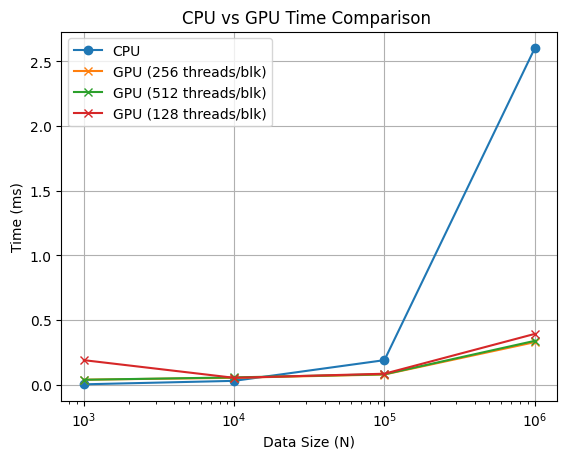

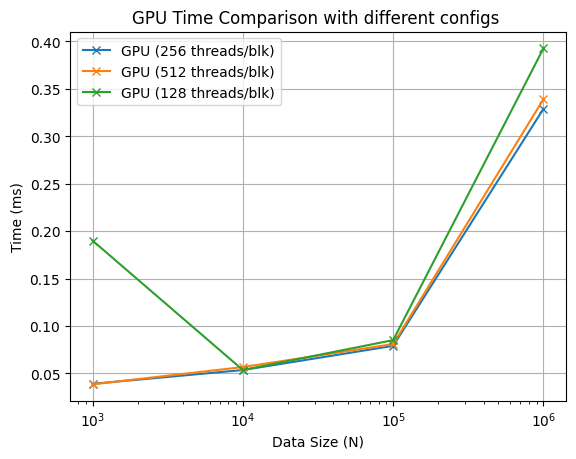

In [1]:
import matplotlib.pyplot as plt


N = [1000, 10000, 100000, 1000000] # dataset sizes
cpu_times = [0.0032, 0.03, 0.19, 2.6]  # CPU times in seconds
gpu_times_128_threads = [0.189984, 0.053504, 0.085056, 0.392768]  # GPU times for 128 threads in seconds
gpu_times_256_threads = [0.038944, 0.053504, 0.079008, 0.329024]  # GPU times for 256 threads in seconds
gpu_times_512_threads = [0.038432, 0.056640 , 0.080896 , 0.339168] # GPU times for 512 threads in seconds
# logarithmic plot

# comment out other plot lines if you want to view one

plt.plot(N, cpu_times, label='CPU', marker='o')

# Plotting GPU times
plt.plot(N, gpu_times_256_threads, label='GPU (256 threads/blk)', marker='x')

plt.plot(N, gpu_times_512_threads, label='GPU (512 threads/blk)', marker='x')

plt.plot(N, gpu_times_128_threads, label='GPU (128 threads/blk)', marker='x')


plt.xlabel('Data Size (N)')
plt.ylabel('Time (ms)')
plt.xscale("log")
plt.title('CPU vs GPU Time Comparison ')
plt.legend()
plt.grid(True)
plt.show()



# times (GPU only)

# plt.plot(N, cpu_times, label='CPU', marker='o')

# Plotting GPU times
plt.plot(N, gpu_times_256_threads, label='GPU (256 threads/blk)', marker='x')

plt.plot(N, gpu_times_512_threads, label='GPU (512 threads/blk)', marker='x')

plt.plot(N, gpu_times_128_threads, label='GPU (128 threads/blk)', marker='x')


plt.xlabel('Data Size (N)')
plt.ylabel('Time (ms)')
plt.xscale("log")
plt.title('GPU Time Comparison with different configs ')
plt.legend()
plt.grid(True)
plt.show()


#### Observations

- We observe that for different configurations, the GPU time taken are similar. Compared to the CPU time, we see that for small datasets (N = 1000), the CPU takes lesser time than GPU. This may be because of the extra overhead cost for smaller no of elements. However, as datasets grow larger, we see that the GPU speed up grows exponentially (i.e GPU performs significantly better along different configurations) as depicted in the graph. This is beacuse GPU can sum in logarithmic time due to availability of a large number of cores and threads while CPU has to calculate the sums sequentially. As the data sets will grow larger, the performance difference will increase (within the physical limits of GPU).

- We also note that for N=1000 at 128 threads/block, the GPU takes somewhat more time than other configurations. This might be because of the unknown overhead that the configuration could be introducing for the small dataset.